In [79]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mido
from music21 import midi

In [80]:
datasets = ['data/jsb_chorales.pickle', 'data/piano_midi.pickle', 
            'data/muse_data.pickle', 'data/nottingham.pickle']
data_datasets = dict()
for path in datasets:
    with open(path, 'rb') as file:
        data_datasets[ os.path.splitext(os.path.basename(path))[0] ] = pickle.load(file)

In [81]:
def midi_to_song(data):
    # Create a MIDI file
    midi_file = MIDIFile(1)  # One track
    track = 0
    time = 0  # Start at the beginning
    midi_file.addTrackName(track, time, "Track")
    midi_file.addTempo(track, time, 120)  # Set the tempo

    # Add notes to the MIDI file
    for chord in data:  # Assuming you're using the first song
        duration = 1  # Duration of each chord, you can change this
        for note in chord:
            # channel set to 0, volume 100
            midi_file.addNote(track, 0, note, time, duration, 100)  
        time += duration

    # Write the MIDI file to disk
    with open("output.mid", "wb") as output_file:
        midi_file.writeFile(output_file)

    # Synthesize MIDI to WAV using FluidSynth
    fs = FluidSynth('default.sf2')
    fs.midi_to_audio('output.mid', 'output.wav')

    # Convert WAV to MP3
    audio = AudioSegment.from_wav('output.wav')
    audio.export('output.mp3', format='mp3')

In [82]:
def get_len(x):
    return len(x) if (x is not None) else None

def get_array(x, max_len):
    if max_len and x and max_len>=len(x):
        max_len = int(max_len)
        a = [item for item in x]
        b = (max_len - len(x))*[-1]
        return (a+b)
    else:
        return x   

In [107]:
#converts all elements of each song to the same number of notes
dfs = dict()
for item in data_datasets:
    data = data_datasets[item]
    print(f'number of songs in {item}: ', len(data['train']))
    df = pd.DataFrame(data['train'])
    dfs[item] = df
    for i in range(len(data['train'])): #for each song
        lens = df.iloc[i].apply(lambda x: get_len(x))
        max_len = max(lens)    
        df.iloc[i] = df.iloc[i].apply(lambda x: get_array(x, max_len))
#     print(df.info())

number of songs in jsb_chorales:  229
number of songs in piano_midi:  87
number of songs in muse_data:  524
number of songs in nottingham:  694


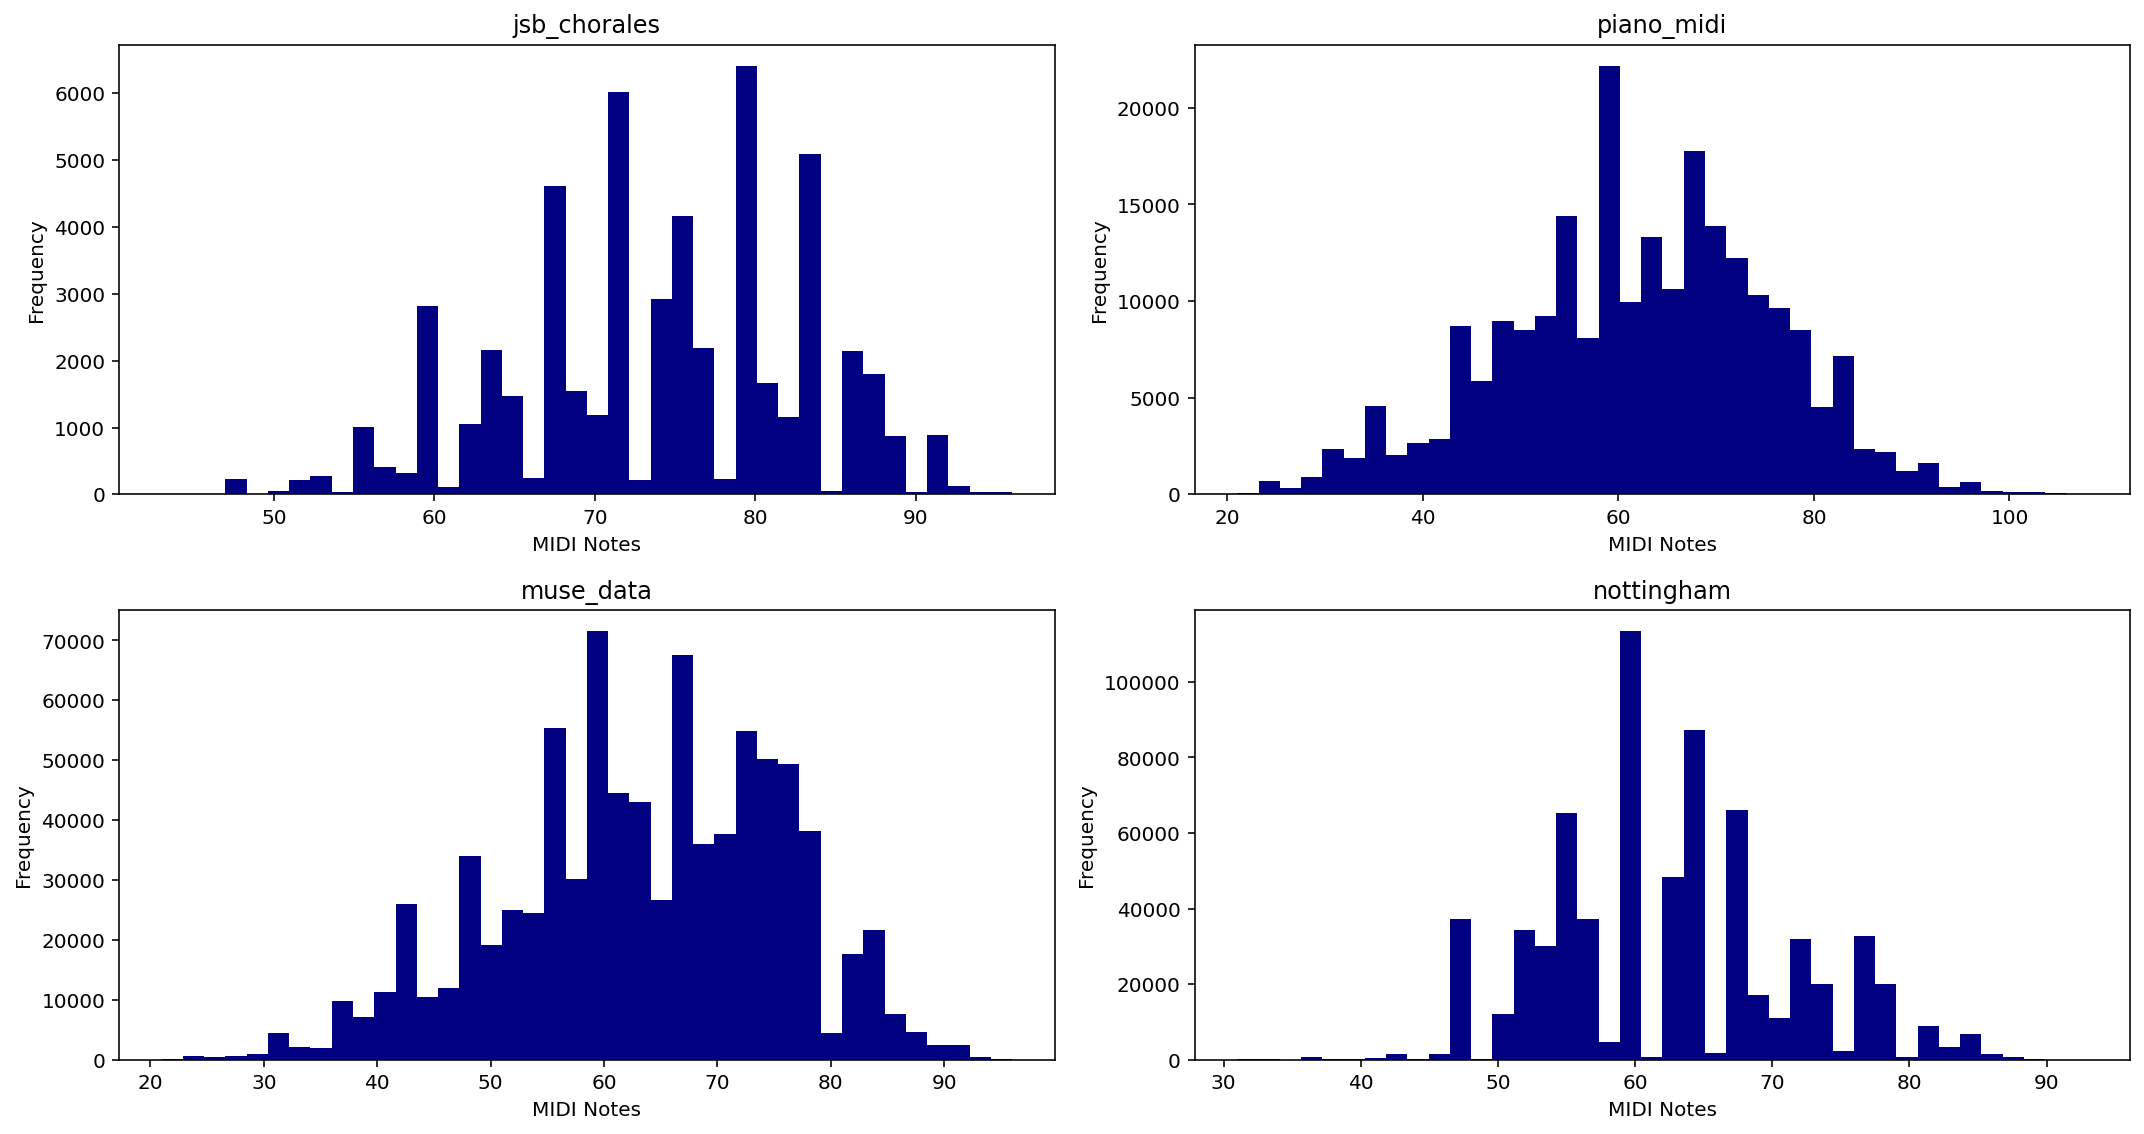

In [84]:
def get_notes(df):
    l = []
    for j in range(len(df)):
        if len(df.iloc[j])>0:
            for i in df.iloc[j]:
                if i:
                    for b in i:
                        l.append(b)
    l = sorted(l)
    l = [item for item in l if item>=0]
    return l

fig, ax = plt.subplots(2, 2, figsize=(15,8))

for j, item in enumerate(dfs):
    l = get_notes(dfs[item])
    ax[j//2, j%2].hist(l, bins=40, color='navy')
    ax[j//2, j%2].set_title(f'{item}')
    ax[j//2, j%2].set_xlabel(f'MIDI Notes')
    ax[j//2, j%2].set_ylabel(f'Frequency')
    
    
plt.tight_layout()
# plt.show()
plt.savefig('notes_hist.pdf')

25 129
111 3857
9 3457
40 1788


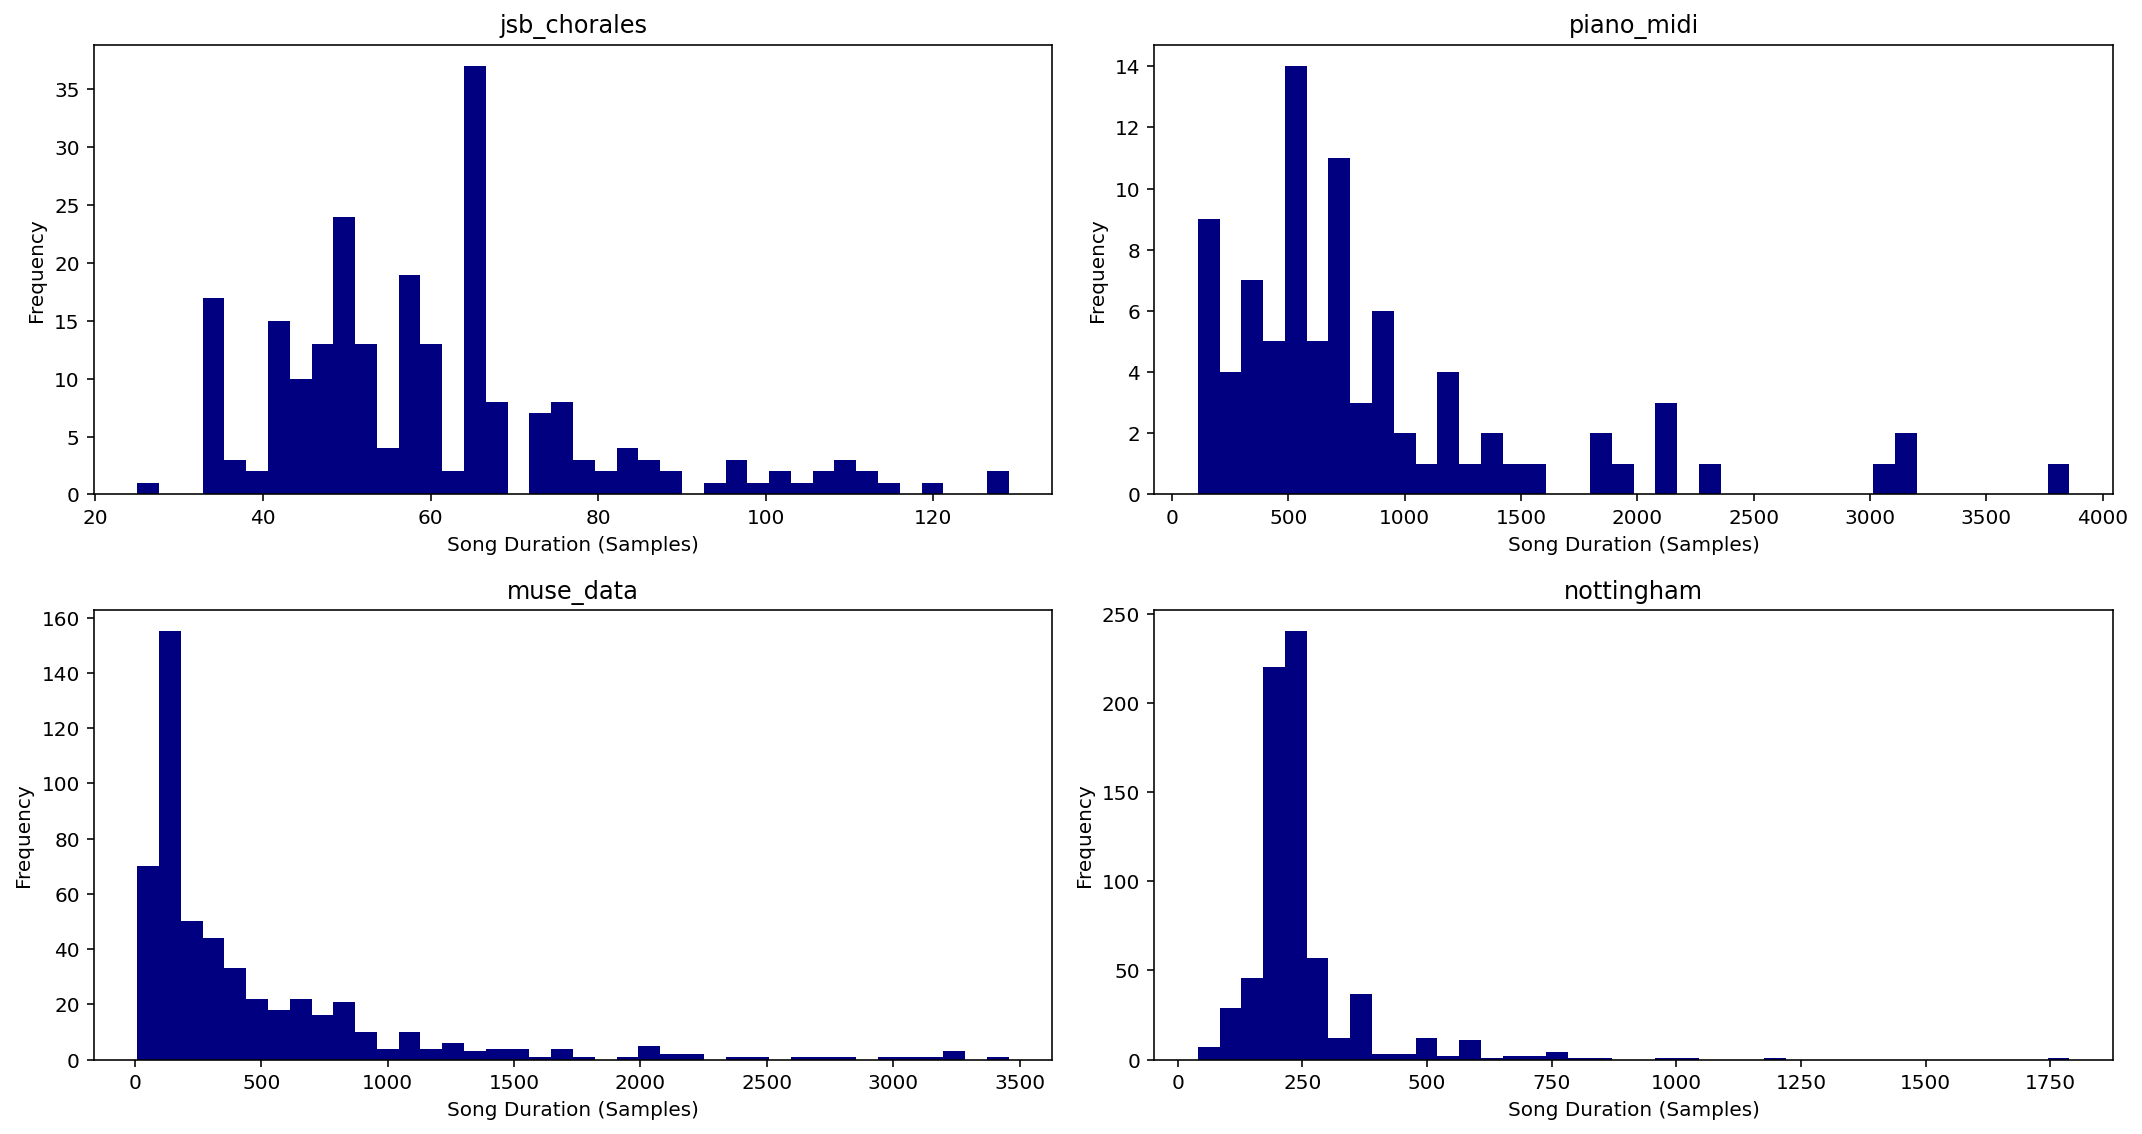

In [92]:
def get_durations(data):
    durations = []
    for i in range(len(data['train'])):
        durations.append(len(data['train'][i]))
    return durations   
    
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for j, item in enumerate(dfs.keys()):
    durations = get_durations(data_datasets[item])    
    ax[j//2, j%2].hist(durations, bins=40, color='navy')
    ax[j//2, j%2].set_title(f'{item}')
    ax[j//2, j%2].set_xlabel(f'Song Duration (Samples)')
    ax[j//2, j%2].set_ylabel(f'Frequency')
    print(min(durations), max(durations))
      
plt.tight_layout()
# plt.show()
plt.savefig('dur_hist.pdf')

In [86]:
def get_top_notes(df):
    l = get_notes(df)
    a = np.bincount(l)
    d = dict(zip(range(len(a)), a))
    top_notes = list({k: v for k, v in sorted(
        d.items(), key=lambda item: item[1])[-10:]}.keys())[::-1]
    return top_notes, l


for item in dfs.keys():
    top_notes, l = get_top_notes(dfs[item])
    print(f'Most frequent notes in {item}: {top_notes}')
    print(f'Median Note: {np.median(l)} \nMinimum Note: {min(l)} \nMaximum Note: {max(l)}')
    print(40*'=')

Most frequent notes in jsb_chorales: [79, 72, 67, 84, 74, 60, 76, 77, 86, 75]
Median Note: 74.0 
Minimum Note: 43 
Maximum Note: 96
Most frequent notes in piano_midi: [67, 60, 55, 72, 62, 65, 48, 64, 79, 43]
Median Note: 63.0 
Minimum Note: 21 
Maximum Note: 108
Most frequent notes in muse_data: [67, 72, 60, 55, 62, 74, 79, 48, 64, 69]
Median Note: 64.0 
Minimum Note: 21 
Maximum Note: 96
Most frequent notes in nottingham: [60, 67, 55, 64, 62, 48, 57, 52, 72, 65]
Median Note: 62.0 
Minimum Note: 31 
Maximum Note: 93


In [87]:
min(get_notes(df)), max(get_notes(df))

(31, 93)

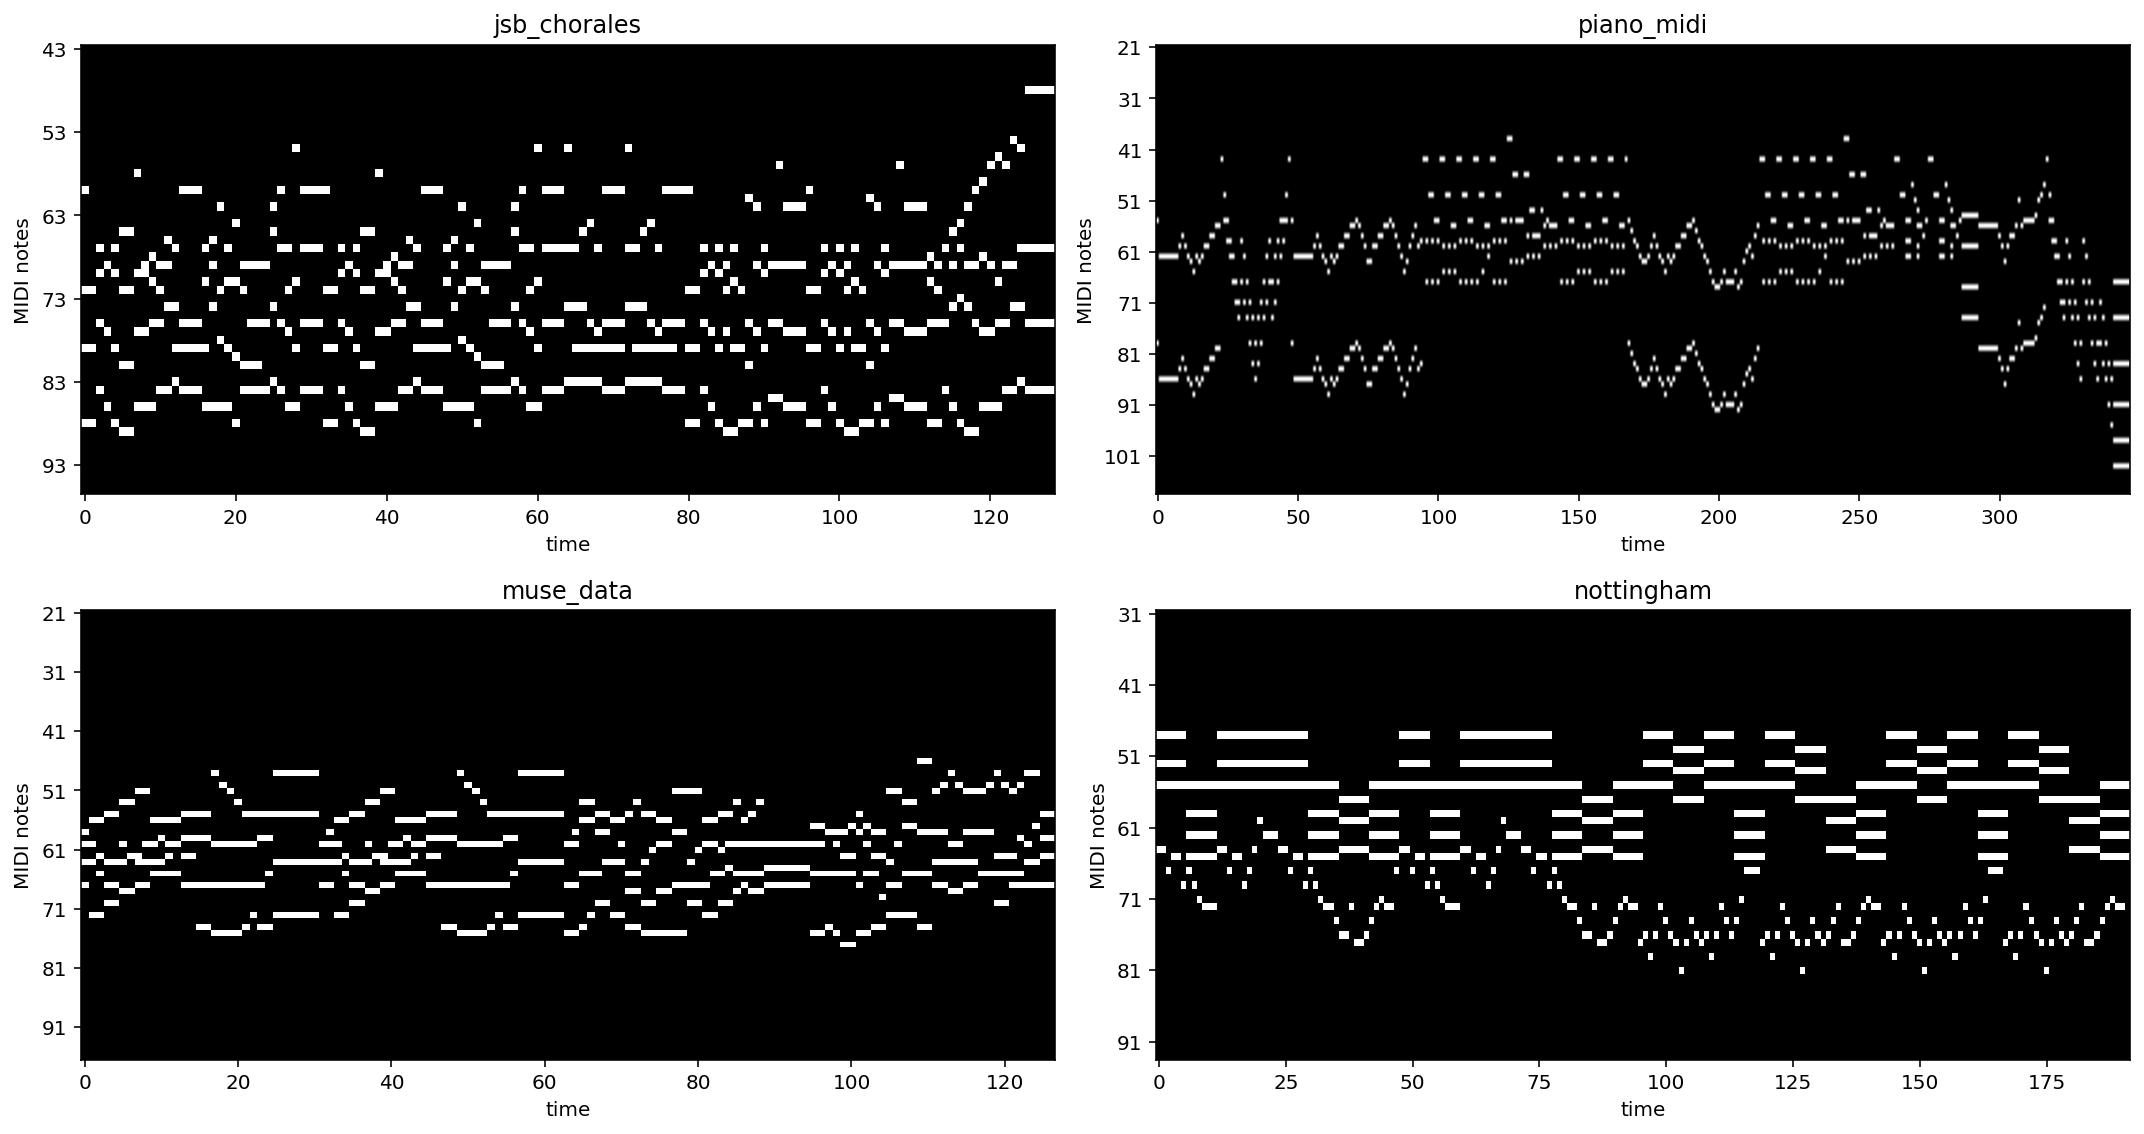

In [97]:
def one_hot(a, min_note=43, max_note=96):
    b = np.zeros(((max_note - min_note + 1,)))
    a = a[np.where(a!=-1)]
    b[list(np.array(a) - min_note)] = 1
    return b

num_songs = 1

fig, ax = plt.subplots(2, 2, figsize=(15,8))

for m in range(len(dfs)):
    dataset_name = list(data_datasets.keys())[m]    
    df = dfs[dataset_name]
    min_note, max_note = min(get_notes(df)), max(get_notes(df))
    
    for j in range(num_songs):
        c = df.iloc[j]
        c = c[c.apply(lambda x: x is not None)]
        a = np.stack(c)
        a_one_hot = np.zeros((a.shape[0], max_note-min_note+1))
        for i in range(a.shape[0]):
            a_one_hot[i] = one_hot(a[i], min_note, max_note)
    #     a_one_hot = np.concatenate((np.zeros((a_one_hot.shape[0], min_note//2)) ,  a_one_hot), axis=1)
    #     a_one_hot = np.concatenate((a_one_hot, np.zeros((a_one_hot.shape[0], min_note//2))  ), axis=1)
        ax[m//2, m%2].imshow(a_one_hot.T, cmap='gray', aspect="auto")
    
        plt.sca(ax[m//2, m%2])
        plt.yticks(range(0, a_one_hot.shape[1], 10), range(min_note, min_note+a_one_hot.shape[1], 10) )

        ax[m//2, m%2].set_title(f'{dataset_name}')
        ax[m//2, m%2].set_xlabel('time')
        ax[m//2, m%2].set_ylabel('MIDI notes')

plt.tight_layout()
plt.savefig('dataset_samples.pdf')
        